# Doing inference with SageMaker Built-in Object Detection model

1. [Download the trained model artifact](#download)
1. [Convert training model to deployable model](#convert)
1. [Inference](#inference)
  1. [model load](#load)
  1. [single image inference](#singleinference)
  1. [batch inference](#batchinference)


In [1]:
%matplotlib inline

In [2]:
!pip install opencv-python
!pip install gluoncv

    100% |████████████████████████████████| 26.6MB 1.3MB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 348kB 27.3MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 28.3MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from matplotlib import pyplot as plt
from gluoncv.utils import download, viz
import numpy as np
import mxnet as mx
import json
import boto3
import cv2

# Download the trained model artifact <a id='download'></a>


In [4]:
JOB_ID='simple-train-resnet-50-simple-augmentation-2'

In [5]:
sagemaker_client =  boto3.client('sagemaker')
MODEL_ARTIFACT = sagemaker_client.describe_training_job(TrainingJobName=JOB_ID)['ModelArtifacts']['S3ModelArtifacts']
MODEL_ARTIFACT

u's3://tanmcrae-greengrass-blog/training-output/simple-train-resnet-50/output/simple-train-resnet-50-simple-augmentation-2/output/model.tar.gz'

In [6]:
import os 

def make_tmp_folder(folder_name):
    try:
        os.makedirs(folder_name)
    except OSError as e:
        print("{} folder already exists".format(folder_name))

In [7]:
TMP_FOLDER = 'trained-model'
make_tmp_folder(TMP_FOLDER)

!aws s3 cp $MODEL_ARTIFACT $TMP_FOLDER/.

trained-model folder already exists
download: s3://tanmcrae-greengrass-blog/training-output/simple-train-resnet-50/output/simple-train-resnet-50-simple-augmentation-2/output/model.tar.gz to trained-model/model.tar.gz


In [8]:
!tar -xvzf $TMP_FOLDER/model.tar.gz -C $TMP_FOLDER/

model_algo_1-symbol.json
hyperparams.json
model_algo_1-0000.params


# Convert the training model to a deployable model <a id='convert'></a>

Make sure to clone this Git repo to your ~/SageMaker folder

```
cd ~/SageMaker
git clone https://github.com/zhreshold/mxnet-ssd.git
```

In [9]:
!python /home/ec2-user/SageMaker/mxnet-ssd/deploy.py -h

Using mxnet as:
<module 'mxnet' from '/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/mxnet/__init__.pyc'>
(export MXNET_EXAMPLE_SSD_DISABLE_PRE_INSTALLED=1) to prevent loading pre-installed mxnet.
usage: deploy.py [-h] [--network NETWORK] [--epoch EPOCH] [--prefix PREFIX]
                 [--data-shape DATA_SHAPE] [--num-class NUM_CLASSES]
                 [--nms NMS_THRESH] [--force FORCE_NMS] [--topk NMS_TOPK]

Convert a trained model to deploy model

optional arguments:
  -h, --help            show this help message and exit
  --network NETWORK     which network to use
  --epoch EPOCH         epoch of trained model
  --prefix PREFIX       trained model prefix
  --data-shape DATA_SHAPE
                        data shape
  --num-class NUM_CLASSES
                        number of classes
  --nms NMS_THRESH      non-maximum suppression threshold, default 0.5
  --force FORCE_NMS     force non-maximum suppression on different class
  --topk NMS_TOPK       apply nms o

In [10]:
!python /home/ec2-user/SageMaker/mxnet-ssd/deploy.py --network resnet50 --num-class 2 --nms .45 --data-shape 512 --prefix $TMP_FOLDER/model_algo_1

Using mxnet as:
<module 'mxnet' from '/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/mxnet/__init__.pyc'>
(export MXNET_EXAMPLE_SSD_DISABLE_PRE_INSTALLED=1) to prevent loading pre-installed mxnet.
Saved model: trained-model/deploy_model_algo_1-0000.params
Saved symbol: trained-model/deploy_model_algo_1-symbol.json


In [11]:
!ls -alh $TMP_FOLDER

total 308M
drwxrwxr-x  2 ec2-user ec2-user 4.0K May 24 18:06 .
drwxrwxr-x 10 ec2-user ec2-user 4.0K May 24 15:48 ..
-rw-rw-r--  1 ec2-user ec2-user 106M May 24 18:06 deploy_model_algo_1-0000.params
-rw-rw-r--  1 ec2-user ec2-user 129K May 24 18:06 deploy_model_algo_1-symbol.json
-rw-r--r--  1 ec2-user ec2-user  678 May 23 06:42 hyperparams.json
-rw-r--r--  1 ec2-user ec2-user 106M May 23 06:42 model_algo_1-0000.params
-rw-r--r--  1 ec2-user ec2-user 130K May 23 06:42 model_algo_1-symbol.json
-rw-rw-r--  1 ec2-user ec2-user  98M May 23 06:43 model.tar.gz


In [13]:
!aws s3 cp $TMP_FOLDER/deploy_model_algo_1-0000.params s3://tanmcrae-greengrass-blog/deployable-model/
!aws s3 cp $TMP_FOLDER/deploy_model_algo_1-symbol.json s3://tanmcrae-greengrass-blog/deployable-model/

upload: trained-model/deploy_model_algo_1-0000.params to s3://tanmcrae-greengrass-blog/deployable-model/deploy_model_algo_1-0000.params
upload: trained-model/deploy_model_algo_1-symbol.json to s3://tanmcrae-greengrass-blog/deployable-model/deploy_model_algo_1-symbol.json


# Doing inference with the model <a id='inference'></a>

In [14]:
def get_ctx():
    try:
        gpus = mx.test_utils.list_gpus()
        if len(gpus) > 0:
            ctx = []
            for gpu in gpus:
                ctx.append(mx.gpu(gpu))
        else:
            ctx = [mx.cpu()]
    except:
        ctx = [mx.cpu()]
    return ctx

ctx = get_ctx()[0]
ctx

gpu(0)

In [15]:
SHAPE = 512
input_shapes=[('data', (1, 3, SHAPE, SHAPE))]
confidence_threshold = 0.3
CLASSES = ['blue box', 'yellow box']


## loading the model <a id="load"> </a>

In [16]:
%%time

param_path=os.path.join(TMP_FOLDER, 'deploy_model_algo_1')
print("param_path: {}".format(param_path))
sym, arg_params, aux_params = mx.model.load_checkpoint(param_path, 0)
mod = mx.mod.Module(symbol=sym, label_names=[], context=ctx)
mod.bind(for_training=False, data_shapes=input_shapes)
mod.set_params(arg_params, aux_params)

param_path: trained-model/deploy_model_algo_1
CPU times: user 6.11 s, sys: 1.08 s, total: 7.19 s
Wall time: 47.5 s


In [17]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def predict_from_file(filepath, reshape=(SHAPE, SHAPE)):
    # Switch RGB to BGR format (which ImageNet networks take)
    img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    if img is None:
        return []

     # Resize image to fit network input
    img = cv2.resize(img, reshape)
    
    org_image = img.copy()
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
 
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)

    return prob, org_image

In [18]:
def infer(image_path, threshold=confidence_threshold):
    results, org_image = predict_from_file(image_path)
    image_name = image_path.split("/")[-1]
    
    filtered_result = results[results[:, 0] != -1]
    filtered_result = filtered_result[filtered_result[:, 1] >=threshold]
    
    return filtered_result, org_image

## Test inference on single image <a id="singleinference"></a>

In [19]:
!aws s3 cp s3://tanmcrae-greengrass-blog/frames/validation_box_video/validation_box_video_000298.jpg .

download: s3://tanmcrae-greengrass-blog/frames/validation_box_video/validation_box_video_000298.jpg to ./validation_box_video_000298.jpg


In [20]:
%%time

prediction_image = 'validation_box_video_000298.jpg'
results, org_image = infer(prediction_image)

CPU times: user 409 ms, sys: 1.23 s, total: 1.64 s
Wall time: 4.71 s


In [21]:
results[:, (2, 4)] *= SHAPE
results[:, (3, 5)] *= SHAPE

In [22]:
org_image.shape

(512, 512, 3)

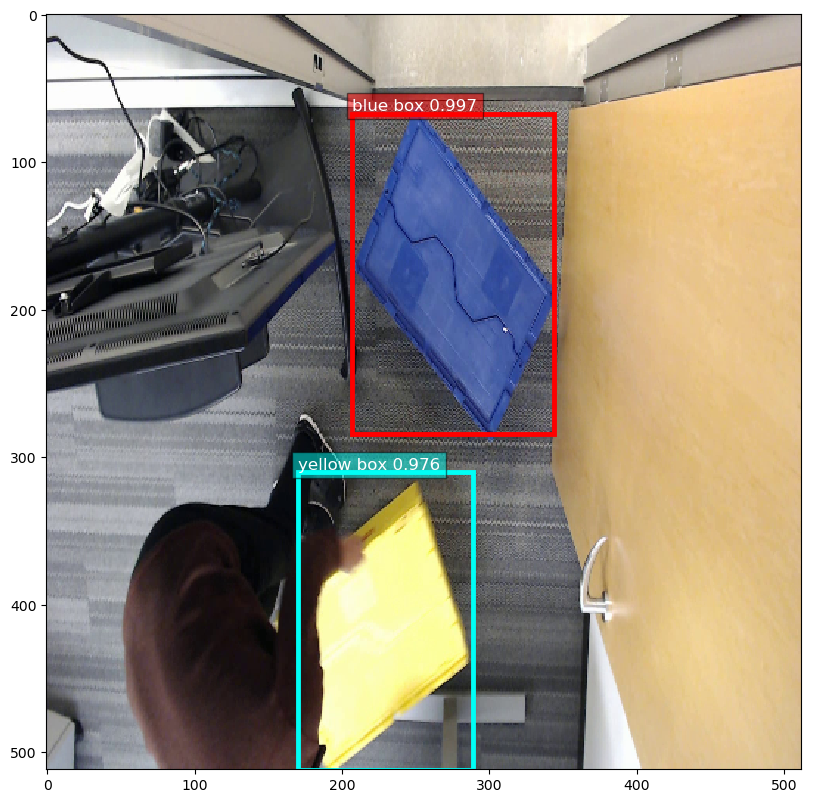

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), facecolor='white', dpi=100)
axis=axes

ax = viz.plot_bbox(org_image, results[:,-4:], results[:,1], results[:,0],thresh=0.1, class_names=CLASSES, ax=axis)

## Run inference on a data set <a id="singleinference"></a>

In [24]:
VALIDATION_IMAGE_FOLDER = 'validation'
make_tmp_folder(VALIDATION_IMAGE_FOLDER)

validation folder already exists


In [25]:
!aws s3 sync s3://tanmcrae-greengrass-blog/frames/validation_box_video/ $VALIDATION_IMAGE_FOLDER/ --quiet

In [26]:
!ls -1 $VALIDATION_IMAGE_FOLDER/ | wc -l

469


In [27]:
%%time 

img_list = os.listdir(VALIDATION_IMAGE_FOLDER)

output_file = 'validation-inference-results.json'
with open(output_file, "w") as outfile:
    for img in img_list:
        if img.endswith("jpg"):
            result,_orig = infer(os.path.join(VALIDATION_IMAGE_FOLDER, img))
            to_write = {"image": img, "prediction": result.tolist()}
            outfile.write(json.dumps(to_write))
            outfile.write('\n')

CPU times: user 24.2 s, sys: 10.5 s, total: 34.8 s
Wall time: 16 s


In [28]:
!head $output_file


{"image": "validation_box_video_000051.jpg", "prediction": [[1.0, 0.9948040843009949, 0.2508499026298523, 0.4963111877441406, 0.5935035943984985, 0.9955235719680786]]}
{"image": "validation_box_video_000356.jpg", "prediction": [[1.0, 0.5674044489860535, 0.19360361993312836, 0.5743646621704102, 0.43063145875930786, 1.0]]}
{"image": "validation_box_video_000224.jpg", "prediction": [[1.0, 0.9959633350372314, 0.40807682275772095, 0.5267037749290466, 0.6534001231193542, 0.8229424357414246]]}
{"image": "validation_box_video_000325.jpg", "prediction": [[0.0, 0.9944348931312561, 0.40240296721458435, 0.12786342203617096, 0.6764340400695801, 0.5438335537910461]]}
{"image": "validation_box_video_000419.jpg", "prediction": [[0.0, 0.9985377788543701, 0.3822726607322693, 0.09006282687187195, 0.7248784899711609, 0.4737687408924103]]}
{"image": "validation_box_video_000015.jpg", "prediction": []}
{"image": "validation_box_video_000275.jpg", "prediction": [[0.0, 0.9485000967979431, 0.3787875473499298, 

In [29]:
visualization_pdf_name = 'validation-visualization.pdf'

In [30]:
!python ./07_visualize_prediction_labels_batch.py -i $VALIDATION_IMAGE_FOLDER -l $output_file -f $visualization_pdf_name -c $confidence_threshold

INFO:__main__:doing inference for images in directory: validation
INFO:__main__:confidence filter: 0.3
INFO:__main__:output file name: validation-visualization.pdf
INFO:__main__:label file name: validation-inference-results.json. number of labels: 469
INFO:__main__:page number: 0, row number: 5, beginning index: 0, last index: 15
INFO:__main__:page number: 1, row number: 5, beginning index: 15, last index: 30
INFO:__main__:page number: 2, row number: 5, beginning index: 30, last index: 45
INFO:__main__:page number: 3, row number: 5, beginning index: 45, last index: 60
INFO:__main__:page number: 4, row number: 5, beginning index: 60, last index: 75
INFO:__main__:page number: 5, row number: 5, beginning index: 75, last index: 90
INFO:__main__:page number: 6, row number: 5, beginning index: 90, last index: 105
INFO:__main__:page number: 7, row number: 5, beginning index: 105, last index: 120
INFO:__main__:page number: 8, row number: 5, beginning index: 120, last index: 135
INFO:__main__:p

In [31]:
!aws s3 cp $visualization_pdf_name s3://tanmcrae-greengrass-blog/prediction-visualization/

upload: ./validation-visualization.pdf to s3://tanmcrae-greengrass-blog/prediction-visualization/validation-visualization.pdf
